In [18]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import torch
import numpy as np
import imageio.v3 as io
from pathlib import Path
from pathlib import Path
import torch.nn.functional as F

from demo_utils import ( 
    plot_imgs, 
    compute_relative_pose, 
    plot_imgs_and_kpts, 
    compute_fundamental_from_relative_motion
)

from matchers.mnn import MNN
matcher = MNN(min_score=0.5, ratio_test=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


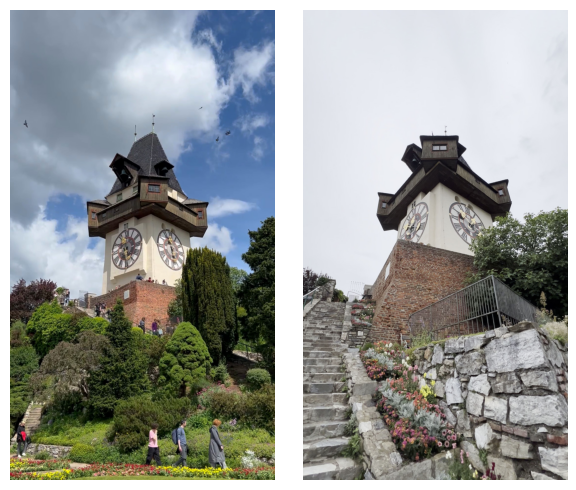

Image A shape: (3840, 2160, 3), Image B shape: (3840, 2160, 3)


In [19]:
## load images
base_path = Path('assets') 

im_A_path = '26/IMG_4057_frame_000001.jpg' # 
im_B_path = '13/IMG_5058_frame_000003.jpg' 

img_A_np = io.imread(base_path / 'frames' / im_A_path)
img_B_np = io.imread(base_path / 'frames' / im_B_path)

plot_imgs([img_A_np, img_B_np])
print(f'Image A shape: {img_A_np.shape}, Image B shape: {img_B_np.shape}')

In [20]:
# load pose 
poses   = np.load(base_path / 'cameras/poses.npz', allow_pickle=True)
cameras = np.load(base_path / 'cameras/cameras.npz', allow_pickle=True)
pose_A, cam_id_A = poses[im_A_path].item()['P'], poses[im_A_path].item()['camera_id']
pose_B, cam_id_B = poses[im_B_path].item()['P'], poses[im_B_path].item()['camera_id']

K_A = cameras[str(cam_id_A)].item()['K']
K_B = cameras[str(cam_id_B)].item()['K']
R_A, t_A = pose_A[:3,:3], pose_A[:3,3]
R_B, t_B = pose_B[:3,:3], pose_B[:3,3]

R, t = compute_relative_pose(R_A, t_A, R_B, t_B)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
down_scaling_factor = 2 # 4K: 1, QHD: 1.5, FHD: 2, HD: 3
max_kpts = 2048

from wrappers_manager import wrappers_manager

wrapper_engine = 'aliked'  # 'superpoint', 'disk', 'dedode', 'aliked'
wrapper = wrappers_manager(wrapper_engine, device=device)

Creating wrapper for aliked on device cuda.

Using automatic mixed precision.
loading /home/mattia/Desktop/Repos/wrapper_factory/methods/aliked/models/aliked-n16rot.pth


In [22]:
# optional image down scaling
if down_scaling_factor != 1:
    K_A = K_A.copy()
    K_B = K_B.copy()
    K_A[:2, :] /= down_scaling_factor
    K_B[:2, :] /= down_scaling_factor
    img_A_np = cv2.resize(img_A_np, None, fx=1/down_scaling_factor, fy=1/down_scaling_factor, interpolation=cv2.INTER_AREA)
    img_B_np = cv2.resize(img_B_np, None, fx=1/down_scaling_factor, fy=1/down_scaling_factor, interpolation=cv2.INTER_AREA)
    print(img_A_np.shape, img_B_np.shape)

F_gt = compute_fundamental_from_relative_motion(R, t, K_A, K_B)

img_A = wrapper.img_from_numpy(img_A_np).to(device)
img_B = wrapper.img_from_numpy(img_B_np).to(device)

(1920, 1080, 3) (1920, 1080, 3)


In [23]:
with torch.inference_mode():
    out1 = wrapper.extract(img_A, max_kpts=max_kpts)
    out2 = wrapper.extract(img_B, max_kpts=max_kpts)

kpts1, des1 = out1.kpts, out1.des
kpts2, des2 = out2.kpts, out2.des
print(kpts1.shape, des1.shape, kpts2.shape, des2.shape)

matches = matcher.match([des1], [des2])[0].matches
kpts1_matched = kpts1[matches[:, 0]].cpu().numpy()
kpts2_matched = kpts2[matches[:, 1]].cpu().numpy()
print('matched:', kpts1_matched.shape, kpts2_matched.shape)

torch.Size([2022, 2]) torch.Size([2022, 128]) torch.Size([2020, 2]) torch.Size([2020, 128])
matched: (429, 2) (429, 2)


R error: 21.94, t error: 14.94
Reprojection error threshold: 5 pixels
Inliers: 4/25


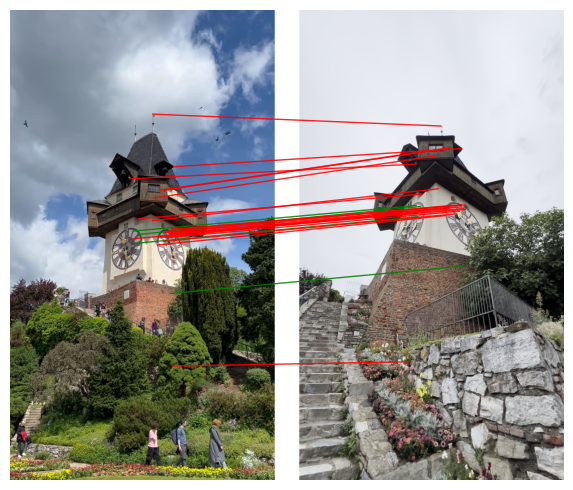

In [24]:
from benchmarks.benchmark_utils import estimate_pose, compute_pose_error

norm_threshold = 0.5 / (np.mean(np.abs(K_A[:2, :2])) + np.mean(np.abs(K_B[:2, :2])))
R_est, t_est, mask = estimate_pose(
    kpts1_matched, kpts2_matched,
    K_A, K_B, norm_threshold
)

P = np.hstack((R, t.reshape(3,1)))
pose_err = compute_pose_error(P, R_est, t_est)
print(f'R error: {pose_err[0]:.2f}, t error: {pose_err[1]:.2f}')

plot_imgs_and_kpts(img_A_np, img_B_np, 
                kpts1_matched[mask], kpts2_matched[mask], # keeping only geometrically verified matches
                scatter=False, F_gt=F_gt, reth=5,
                highlight_bad_matches=True)

In [25]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

### Extraction with SANDesc

In [27]:
path = f'sandesc_models/{wrapper_engine.split("-")[0]}/final.pth'

weights = torch.load(path,  map_location=device, weights_only=False)
config = weights['config']
model_config = {'ch_in': config['model_config']['unet_ch_in'],
                'kernel_size': config['model_config']['unet_kernel_size'],
                'activ': config['model_config']['unet_activ'],
                'norm': config['model_config']['unet_norm'],
                'skip_connection': config['model_config']['unet_with_skip_connections'],
                'spatial_attention': config['model_config']['unet_spatial_attention'],
                'third_block': config['model_config']['third_block'],
                }

from sandesc_models.sandesc.network_descriptor import SANDesc
network = SANDesc(**model_config).eval().to(device)

network.load_state_dict(weights['state_dict'])
wrapper.descriptor_network = network
wrapper.add_custom_descriptors(network)

In [28]:
with torch.inference_mode():
    out1 = wrapper.extract(img_A, max_kpts=max_kpts)
    out2 = wrapper.extract(img_B, max_kpts=max_kpts)

kpts1, des1 = out1.kpts, out1.des
kpts2, des2 = out2.kpts, out2.des
print(kpts1.shape, des1.shape, kpts2.shape, des2.shape)

matches = matcher.match([des1], [des2])[0].matches
kpts1_matched = kpts1[matches[:, 0]].cpu().numpy()
kpts2_matched = kpts2[matches[:, 1]].cpu().numpy()
print(kpts1_matched.shape, kpts2_matched.shape)

torch.Size([2022, 2]) torch.Size([2022, 128]) torch.Size([2020, 2]) torch.Size([2020, 128])
(75, 2) (75, 2)


R error: 0.68, t error: 0.87
Reprojection error threshold: 5 pixels
Inliers: 11/41


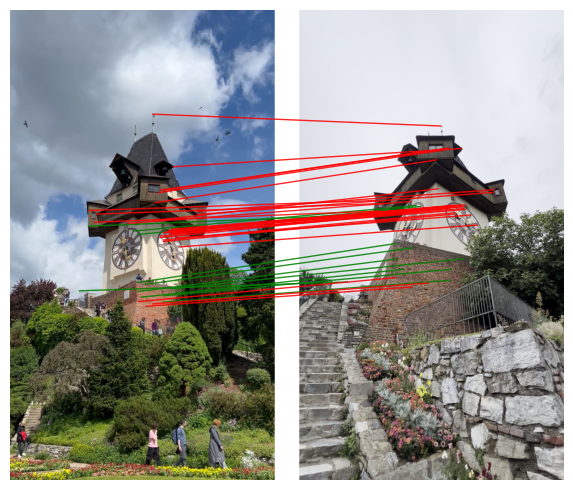

In [29]:
norm_threshold = 0.5 / (np.mean(np.abs(K_A[:2, :2])) + np.mean(np.abs(K_B[:2, :2])))
R_est, t_est, mask = estimate_pose(
    kpts1_matched, kpts2_matched,
    K_A, K_B, norm_threshold
)

pose_err = compute_pose_error(P, R_est, t_est)
print(f'R error: {pose_err[0]:.2f}, t error: {pose_err[1]:.2f}')

plot_imgs_and_kpts(img_A_np, img_B_np, 
                kpts1_matched[mask], kpts2_matched[mask], # keeping only geometrically verified matches
                scatter=False, F_gt=F_gt, reth=5,
                highlight_bad_matches=True)